# Training Deep CNN Image Classifier

<img src="https://thumbs.gfycat.com/AngryInconsequentialDiplodocus-size_restricted.gif" width="480" border="1"/>

We can use GPU acceleration in Colab from the menu option `Edit -> Notebook Settings`. You can also try your Tensorflow machine learning project on [Tensor Processing Units (TPUs)](https://cloud.google.com/tpu/docs/tpus).


(*Objective: Implement training process and inference for a CNN image classifier, preprocessing image data*. Time: 20 mins)

In [1]:
# Check GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/OOT2019/lib')

# Display the system path elements
for sFolder in sys.path:
  print(sFolder)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/

/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
/content/gdrive/My Drive/Colab Notebooks/OOT2019/lib


## Convolutional Neural Network (CNN)

The base class with common CNN layers is `:ConvolutionalNeuralNetwork` and will included in our framework in th **ootf.cnn**  namespace 

### Implementation Notes
* The descendant class `:SimpleCNN` creates a custom network overriding the virtual method `CreateModel()`. It also adds additional methods for our training process. 
* The `:ModuleState` is a helper class to save/load the model parameters to/from a file.
*   The private method `__defineCostFunction()` implements L2 regularization by adding a term to the categorial cross entropy loss.


### Theory: The ELU activation function:
*   In this model we are using the [ELU](https://arxiv.org/abs/1511.07289) activation. The ReLU are non-negative so there are no contrastive neurons that try to cancel each other, introducing bias in the subsequent layer.

     <img src="https://cdn.tinymind.com/static/img/learn/elu.png" width="400" border="1"/>

In [3]:
import os
from datetime import datetime
import numpy as np
import tensorflow as tf
from ootf.nn import NeuralNetwork

RANDOM_SEED = 2019

# Make random initialization reproducible
tf.reset_default_graph() 
tf.set_random_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

 
#==================================================================================================  
class ConvolutionalNeuralNetwork(NeuralNetwork):  
    #------------------------------------------------------------------------------------
    def __init__(self, p_nFeatures=[128,256,512,10]):
        #........ |  Instance Attributes | ..............................................
        # // Composite object collections \\
        # ... Weights ...
        self.ConvWeights        = []
        self.ConvBiases         = []
        # ... Layers ...
        self.MaxPoolLayers      = []
        self.AveragePoolLayers  = []
        
        # // Architectural Hyperparameters \\
        self.Features = p_nFeatures
        #................................................................................
        
        # Invoke the inherited logic from ancestor :NeuralNetwork
        super(ConvolutionalNeuralNetwork, self).__init__()
    #------------------------------------------------------------------------------------
    def Convolutional(self, p_tInput, p_nNeuronCount, p_nWindowSize=[3,3], p_nStrides=[1,1], p_bIsPadding=True, p_nPadding=None, p_bHasBias=True, p_tActivationFunction=None):
      nLayerNum = len(self.ConvWeights) + 1
      
      nInputShape  = p_tInput.get_shape().as_list()
      nInFeatures  = nInputShape[3]          
      nKernelShape = list(p_nWindowSize) + [nInFeatures, p_nNeuronCount]
      nStrides     = [1] + list(p_nStrides) + [1]
      tX = p_tInput
      if p_nPadding is not None:
        sPadding = "VALID"
        tX = self.PadSpatial(p_tInput, p_nWindowSize[0], p_nPadding)
      else:      
        if p_bIsPadding:
          sPadding = "SAME"
        else:
          sPadding = "VALID"
      
      sLayerName = "CONV%d" % nLayerNum
      with tf.variable_scope(sLayerName):
        tW = self.GetParameter(nKernelShape, tf.initializers.he_uniform()) #He weight initilization
        tU = tf.nn.conv2d(tX, tW, strides=nStrides, padding=sPadding) 
        
        if p_bHasBias:
          tB = self.GetParameter([p_nNeuronCount], p_bIsBias=True)
          tU = tU + tB
        
        if p_tActivationFunction is not None:
          # Activation function is a function reference that is passed to the method
          tA = p_tActivationFunction(tU)
        else:
          tA = tU
      
        self.ConvWeights.append(tW)
        if p_bHasBias:
          self.ConvBiases.append(tB)
        
      print("    [%s] Input:%s, Kernel:%s, Output:%s" % (sLayerName, nInputShape, nKernelShape, tA.get_shape().as_list()))
      
      return tA
    #------------------------------------------------------------------------------------
    def MaxPool(self, p_tInput, p_nPoolSize=[2,2], p_nPoolStrides=[2,2], p_bIsPadding=True, p_nPadding=None):
      nLayerNum = len(self.MaxPoolLayers) + 1
      nInputShape  = p_tInput.get_shape().as_list()

      tX = p_tInput
      if p_nPadding is not None:
        sPadding = "VALID"
        tX = self.PadSpatial(p_tInput, p_nPoolSize[0], p_nPadding)
      else:      
        if p_bIsPadding:
          sPadding = "SAME"
        else:
          sPadding = "VALID"
        
      nSize = [1] + list(p_nPoolSize) + [1]
      nStrides = [1] + list(p_nPoolStrides) + [1]
       
      sLayerName = "MAXP%d" % nLayerNum
      with tf.variable_scope(sLayerName):
        tA = tf.nn.max_pool(tX, ksize=nSize, strides=nStrides, padding=sPadding)
        self.MaxPoolLayers.append(tA)
      
      print("    [%s] Input:%s, Pool:%dx%d/%s, Output:%s" % (sLayerName, 
                  nInputShape, p_nPoolSize[0], p_nPoolSize[1], p_nPoolStrides[0], tA.get_shape().as_list()))
      
      return tA 
    # --------------------------------------------------------------------------------------------------------
    def AveragePool(self, p_tInput, p_nPoolSize=(2,2), p_nPoolStrides=(2,2), p_bIsPadding=False):
      nLayerNum = len(self.AveragePoolLayers) + 1
      nInputShape  = p_tInput.get_shape().as_list()

      if p_bIsPadding:
        sPadding = "SAME"
      else:
        sPadding = "VALID"
        
      nSize = [1] + list(p_nPoolSize) + [1]
      nStrides = [1] + list(p_nPoolStrides) + [1]
      
      sLayerName = "AVGP%d" % nLayerNum
      with tf.variable_scope(sLayerName):         
        tA = tf.nn.avg_pool(p_tInput, ksize=nSize, strides=nStrides, padding=sPadding)
        self.AveragePoolLayers.append(tA)
        
      print("    [%s] Input:%s, Pool:%dx%d/%s, Output:%s" % (sLayerName, 
                  nInputShape, p_nPoolSize[0], p_nPoolSize[1], p_nPoolStrides[0], tA.get_shape().as_list()))
             
      return tA    
    # --------------------------------------------------------------------------------------------------------
    def Flatten(self, x):
        nFlatConvDims = np.prod(np.asarray(x.get_shape().as_list()[1:]))
        tFlatten = tf.reshape(x, [-1, nFlatConvDims])
        return tFlatten      
    # --------------------------------------------------------------------------------------------------------
    def GlobalAveragePooling(self, p_tInput):
      nInputShape  = p_tInput.get_shape().as_list()
      nPoolSize = [1,nInputShape[1],nInputShape[2],1]
      
      with tf.variable_scope("GAVGPOOL"):
        tA = tf.nn.avg_pool(p_tInput, ksize=nPoolSize, strides=[1,1,1,1], padding="VALID", name="avgpool")
        tA = tf.squeeze(tA, [1,2], name="squeeze")
        
      print("    [GAVGPOOL] Input:%s, Output:%s" % (nInputShape, tA.get_shape().as_list()))
      
      return tA
    # --------------------------------------------------------------------------------------------------------
    
#==================================================================================================









# =======================================================================================================================
class ModelState(object):
    #------------------------------------------------------------------------------------
    def __init__(self, p_oSession, p_sFileName):
      self.Session  = p_oSession
      self.FileName = p_sFileName
      oVarList     = tf.global_variables()
      self.Saver   = tf.train.Saver(oVarList, write_version=2)
    #------------------------------------------------------------------------------------            
    def Save(self):
        print("  |__ Saving Weights to " + self.FileName, end="")
        
        self.Saver.save(self.Session, self.FileName)
        print(" -> Saved.")
    #------------------------------------------------------------------------------------
    def Load(self):
      if os.path.exists(self.FileName + ".meta"):
        print("  |__ Restoring Weights from " + self.FileName, end="")
        self.Saver.restore(self.Session, self.FileName)
        print(' -> Restored.')
        bResult = True
      else:
        bResult = False
        
      return bResult
    # --------------------------------------------------------------------------------------------------------            
    
# =======================================================================================================================





    
#==================================================================================================  
class SimpleCNN(ConvolutionalNeuralNetwork):  
    #------------------------------------------------------------------------------------
    def __init__(self, p_nFeatures=[16,24,32,48,10]):
        #........ |  Instance Attributes | ..............................................
        # // Tensors \\
        self.DropOutKeepProb = None
        self.CCECost        = None
        self.L2Cost         = None
        self.CostFunction   = None
        self.LearningRate   = None
        self.TrainingOp     = None
        
        # // Learning Hyperparameters \\
        self.Momentum     = 0.9
        self.WeightDecay  = 1e-4
        self.DropOutRate   = 0.5
        #................................................................................
        
        # Invoke the inherited logic from ancestor :NeuralNetwork
        super(SimpleCNN, self).__init__(p_nFeatures)
    #------------------------------------------------------------------------------------
    def Feed(self, p_nBatchFeatures, p_nBatchTargets=None, p_nLearningRate=None, p_bIsTraining=False):
      oDict = dict()
      oDict[self.Input]        = p_nBatchFeatures
      
      if p_bIsTraining:
        oDict[self.LearningRate] = p_nLearningRate
        oDict[self.DropOutKeepProb] = self.DropOutRate
        oDict[self.Targets]      = p_nBatchTargets
      else:
        # When the model is trained the neurons are not dropped out
        oDict[self.DropOutKeepProb] = 1.0
      
      return oDict
    # --------------------------------------------------------------------------------------------------------
    def Predict(self, p_oSession, p_oSubSet):   
      nPredictedClasses = np.zeros(p_oSubSet.Labels.shape, np.uint32)
      for nRange, nSamples, nLabels, _ in p_oSubSet:
        nPrediction = p_oSession.run(self.Prediction, feed_dict=self.Feed(nSamples, nLabels))
        nPredictedClasses[nRange] = np.argmax(nPrediction, axis=1).astype(np.uint32)
      
      return nPredictedClasses        
    #------------------------------------------------------------------------------------
    def CreateModel(self):
      with tf.variable_scope("HyperParams"):
        self.DropOutKeepProb = tf.placeholder(tf.float32, shape=())
        
      with tf.variable_scope("NeuralNet"):
        with tf.variable_scope("Input"):
          # None in the first dimension means variable batch size
          self.Input = tf.placeholder(tf.float32, shape=(None,32,32,3))
          self.Targets = tf.placeholder(tf.uint8, shape=(None))

        # First convolutional layer performs downsampling
        tA = self.Convolutional(self.Input, self.Features[0], [3,3], [1,1], p_tActivationFunction=tf.nn.elu)
        
        # Declare 3 modules of 2 convolutions each, followed by a max pooling operation and local response normalization
        for nModuleIndex in range(0, 3):
          sModuleName = "Module%d" % (nModuleIndex + 1)
          
          with tf.variable_scope(sModuleName):
            print(" |_ " + sModuleName)

            # Downsample only at module 2 and 3 
            if nModuleIndex > 0:
              tA = self.MaxPool(tA, [3,3], [2,2])
            
            for _ in range(0, 2):
              tA = self.Convolutional(tA, self.Features[1 + nModuleIndex], [3,3], [1,1], p_tActivationFunction=tf.nn.elu)
              
            tA = tf.nn.lrn(tA)
        
        # The 3D activation volume of a sample is flattened into a vector
        tA = self.Flatten(tA)
        
        # Dropout layer to prevent overfitting in the classification layer
        tA = self.DropOut(tA)
        
        self.Logits     = self.FullyConnected(tA, self.Features[-1])
        self.Prediction = tf.nn.softmax(self.Logits)
        
        self.PredictedClass = tf.argmax(self.Prediction, axis=1)
        
      self.__defineCostFunction()
    # --------------------------------------------------------------------------------------------------------
    def __defineCostFunction(self):
        nClassCount = self.Features[-1]
      
        with tf.variable_scope("Cost"):
            # Multiclass categorical cross entropy (CCE) loss
            tLoss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.Logits, labels=tf.one_hot(self.Targets, depth=nClassCount, dtype=tf.float32))
            self.CCECost  = tf.reduce_mean(tLoss, name="cce")
            
            # L2 weight decay regularizer
            tL2LossesConv = [tf.nn.l2_loss(tKernel) for tKernel in self.ConvWeights]
            tL2LossesFC   = [tf.nn.l2_loss(tWeight) for tWeight in self.FCWeights]
            tL2LossesAll  = tL2LossesConv + tL2LossesFC
            
            self.L2Cost = tf.multiply(tf.constant(self.WeightDecay, tf.float32), tf.add_n(tL2LossesAll), name="l2")

            self.CostFunction = tf.identity(self.CCECost + self.L2Cost, "total_cost")
    # --------------------------------------------------------------------------------------------------------
#==================================================================================================  

  
  
  



oNet = SimpleCNN()

W0826 08:41:43.039811 139692883167104 deprecation_wrapper.py:119] From /content/gdrive/My Drive/Colab Notebooks/OOT2019/lib/ootf/nn.py:40: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0826 08:41:43.040946 139692883167104 deprecation_wrapper.py:119] From /content/gdrive/My Drive/Colab Notebooks/OOT2019/lib/ootf/nn.py:41: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0826 08:41:43.049661 139692883167104 deprecation_wrapper.py:119] From /content/gdrive/My Drive/Colab Notebooks/OOT2019/lib/ootf/nn.py:42: The name tf.train.create_global_step is deprecated. Please use tf.compat.v1.train.create_global_step instead.

W0826 08:41:43.058412 139692883167104 deprecation_wrapper.py:119] From /content/gdrive/My Drive/Colab Notebooks/OOT2019/lib/ootf/nn.py:58: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0826 08:41:43.152428 139692883167104 deprecation.py:506] From /conten

 |_ Creating common neural network tensors
    [CONV1] Input:[None, 32, 32, 3], Kernel:[3, 3, 3, 16], Output:[None, 32, 32, 16]
 |_ Module1
    [CONV2] Input:[None, 32, 32, 16], Kernel:[3, 3, 16, 24], Output:[None, 32, 32, 24]
    [CONV3] Input:[None, 32, 32, 24], Kernel:[3, 3, 24, 24], Output:[None, 32, 32, 24]
 |_ Module2
    [MAXP1] Input:[None, 32, 32, 24], Pool:3x3/2, Output:[None, 16, 16, 24]
    [CONV4] Input:[None, 16, 16, 24], Kernel:[3, 3, 24, 32], Output:[None, 16, 16, 32]
    [CONV5] Input:[None, 16, 16, 32], Kernel:[3, 3, 32, 32], Output:[None, 16, 16, 32]
 |_ Module3
    [MAXP2] Input:[None, 16, 16, 32], Pool:3x3/2, Output:[None, 8, 8, 32]
    [CONV6] Input:[None, 8, 8, 32], Kernel:[3, 3, 32, 48], Output:[None, 8, 8, 48]
    [CONV7] Input:[None, 8, 8, 48], Kernel:[3, 3, 48, 48], Output:[None, 8, 8, 48]
    [DO] Input:[None, 3072], Output:[None, 3072]
    [FC1] Input:[None, 3072], Weights:[3072, 10], Output:[None, 10]


## Loading and preprocessing the data
We load the whole dataset into memory and standardize the RGB pixel values.

### Theory: Z-Score standardization


<img src="http://www.z-table.com/uploads/2/1/7/9/21795380/5175170_orig.gif" width="150"/>

In [4]:
import joblib
from ootf.base import DataSubSet
from ootf.cifar10 import DataSetCifar10

# Loads the dataset
oData = DataSetCifar10(DataSubSet, "/content/gdrive/My Drive/Colab Notebooks/OOT2019/data/cifar10")
oData.Load()
oData.Training.BatchSize=500
oData.Testing.BatchSize=1000

# Z-score standardization for bots sets
# ... We have saved the mean and std for CIFAR10 training subset ...
oDict = joblib.load(r"/content/gdrive/My Drive/Colab Notebooks/OOT2019/data/tfcifar10/meanstd.pkl")
nPixelMean = oDict["mean"]
nPixelStd = oDict["std"]
oData.Training.Samples = (oData.Training.Samples - nPixelMean) / nPixelStd
oData.Testing.Samples = (oData.Testing.Samples - nPixelMean) / nPixelStd


np.set_printoptions(suppress=True)
print("Training subset mean R,G,B:%s " % np.round(np.mean(oData.Training.Samples, axis=(0,1,2)), 6))
print("Testing subset mean R,G,B:%s " % np.round(np.mean(oData.Testing.Samples, axis=(0,1,2)), 6))


Training subset mean R,G,B:[ 0.        0.000004 -0.000009] 
Testing subset mean R,G,B:[0.011394 0.012214 0.014816] 


# Training
![Supervised Learning](https://www.cmu.edu/roboticsacademy/images/Sundry%20Images/1_OnsiteIcon.jpg)

## Initializing optimizer, training operation and session

We are going to use the [:ADAMOptimizer](https://arxiv.org/abs/1412.6980) class, that implements the respective gradient descent method. The method uses exponential moving averages of gradients for adaptive learning. The gradients and the backpropagation operations are created by the `minimize()` method

In [0]:
# Creates the training operation automatically
tOptimizer = tf.train.AdamOptimizer(oNet.LearningRate)
tTrainOp = tOptimizer.minimize(oNet.CostFunction)

In [9]:
# Initializes the session and its variables
print("\n[>] Initializing...")
oSession = tf.Session()
oSession.run(tf.global_variables_initializer())

# Creates helper objects
oState = ModelState(oSession, "/content/gdrive/My Drive/Colab Notebooks/OOT2019/models/simplecnn")              
  
print(" |__ GPU:", tf.test.gpu_device_name())


[>] Initializing...
 |__ GPU: /device:GPU:0


## Main training loop

It requires about 7 minutes for 50 epochs to train the model with ~81.7% accuracy. An epoch is completed when all samples in the training subset are presented to the model.

In [10]:
from sklearn.metrics import accuracy_score

print("[>] Started training at %s ..." % datetime.now() )
      

# Training loop   
nMaxEpochs = 50
nLR = 0.005 

nEpochNumber = 1
nStepNumber = 1
while nEpochNumber <= nMaxEpochs:

  nPredictedClasses = np.zeros(oData.Training.Labels.shape, np.uint32)
  for nRange, nSamples, nLabels, _ in oData.Training:
    oDict = oNet.Feed(nSamples, nLabels, nLR, p_bIsTraining=True)
    oTensorList = [tTrainOp, oNet.CostFunction, oNet.CCECost, oNet.L2Cost, oNet.Prediction, oNet.PredictedClass]
    _, nTrainingTotalLoss, nTrainingCCELoss, nTrainingL2Loss, nPrediction, nPredictedClasses[nRange]  = oSession.run(oTensorList, feed_dict=oDict)
    #nPredictedClasses[nRange] = np.argmax(nPrediction, axis=1).astype(np.uint32)

    if nStepNumber % 100 == 0:
      print('%s [%d] Iteration %6d | LR=%.6f | ERR=%.6f (CCE=%.6f) (WD=%.6F)' % (datetime.now(), nEpochNumber, nStepNumber, nLR
                                              , nTrainingTotalLoss, nTrainingCCELoss, nTrainingL2Loss))

    nStepNumber += 1

    # Learning rate schedule  
    if (nStepNumber == 2500) or (nStepNumber == 3500):
      nLR = nLR / 10.0

  # Calculate the accuracy metric for the training subset
  nTrainAccuracy = accuracy_score(oData.Training.Labels, nPredictedClasses)

  # Evaluation
  if ((nEpochNumber % 4) == 0) or (nEpochNumber == nMaxEpochs):
    nPredictedClasses = oNet.Predict(oSession, oData.Testing)
    # Calculate the accuracy metric for the testing subset
    nTestAccuracy = accuracy_score(oData.Testing.Labels, nPredictedClasses)
    print("[Epoch:%d] Accuracy: Testing=%.2f%% Training=%.2f%% " % (nEpochNumber, nTestAccuracy*100.0, nTrainAccuracy*100.0))


  nEpochNumber += 1

# Save trained network weights 
oState.Save()

oSession.close()
print("[>] Finished training at %s ..." % datetime.now())  

[>] Started training at 2019-08-26 08:45:25.993123 ...
2019-08-26 08:45:34.143080 [1] Iteration    100 | LR=0.005000 | ERR=1.457720 (CCE=1.431115) (WD=0.026605)
2019-08-26 08:45:42.133477 [2] Iteration    200 | LR=0.005000 | ERR=1.195665 (CCE=1.166511) (WD=0.029154)
2019-08-26 08:45:50.169589 [3] Iteration    300 | LR=0.005000 | ERR=1.025279 (CCE=0.993306) (WD=0.031973)
2019-08-26 08:45:58.240129 [4] Iteration    400 | LR=0.005000 | ERR=0.872887 (CCE=0.837784) (WD=0.035103)
[Epoch:4] Accuracy: Testing=69.13% Training=67.68% 
2019-08-26 08:46:06.831391 [5] Iteration    500 | LR=0.005000 | ERR=0.904894 (CCE=0.866756) (WD=0.038138)
2019-08-26 08:46:14.854955 [6] Iteration    600 | LR=0.005000 | ERR=0.793920 (CCE=0.752510) (WD=0.041410)
2019-08-26 08:46:22.841445 [7] Iteration    700 | LR=0.005000 | ERR=0.741175 (CCE=0.696631) (WD=0.044544)
2019-08-26 08:46:30.815686 [8] Iteration    800 | LR=0.005000 | ERR=0.701726 (CCE=0.653767) (WD=0.047959)
[Epoch:8] Accuracy: Testing=75.74% Training=7

# Predicting with a pre-trained model

<img src="https://miro.medium.com/max/3840/1*oB3S5yHHhvougJkPXuc8og.gif" width="480" border="1"/>


## Restoring a saved state
After the model tensors are created in the current graph, a session is initialized and the model parameters are loaded from the saved checkpoint

`/content/gdrive/My Drive/Colab Notebooks/OOT2019/models/simplecnn-data-00000-of-00001`


In [11]:
# Initializes the session and its variables
print("\n[>] Initializing...")
oSession = tf.Session()
oSession.run(tf.global_variables_initializer())

# Creates helper objects
oState = ModelState(oSession, "/content/gdrive/My Drive/Colab Notebooks/OOT2019/models/simplecnn") 

if oState.Load():
  nPredictedClasses = oNet.Predict(oSession, oData.Testing)
  # Calculate the accuracy metric for the testing subset
  nTestAccuracy = accuracy_score(oData.Testing.Labels, nPredictedClasses)
  print("Trained model accuracy:%.2f%%" % (nTestAccuracy*100.0))  
  
  
oSession.close()  

W0826 09:00:52.337269 139692883167104 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.



[>] Initializing...
  |__ Restoring Weights from /content/gdrive/My Drive/Colab Notebooks/OOT2019/models/simplecnn -> Restored.
Trained model accuracy:81.77%


## Neural network inference
The neural network inference is to predict the class given an image. We are going to test our network by recalling images from the web, that will be resized to 32 x 32 in order to fit the pre-trained network input size. This crude downsampling results in loss of visual information that is critical to correctly classify the image.

https://upload.wikimedia.org/wikipedia/commons/thumb/8/8b/Husky_on_San_Francisco_sidewalk.jpg/220px-Husky_on_San_Francisco_sidewalk.jpg


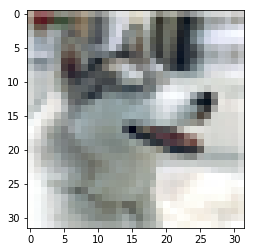

https://upload.wikimedia.org/wikipedia/commons/thumb/b/b1/Hellenic_Hound_aka_Hellinikos_Ichnilatis.jpg/220px-Hellenic_Hound_aka_Hellinikos_Ichnilatis.jpg


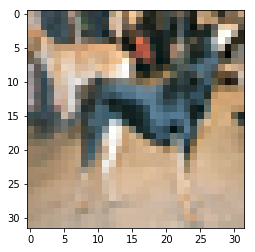

https://vignette.wikia.nocookie.net/dog-breed4080/images/0/0a/GREATER-SWISS-MOUNTAIN-DOG.jpg/revision/latest/scale-to-width-down/230?cb=20171221134620


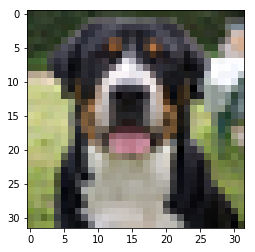

https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/1200px-Cat03.jpg


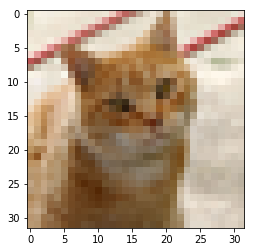

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import requests
from PIL import Image
from io import BytesIO

# ... False predictions ...
IMAGE1 = "https://upload.wikimedia.org/wikipedia/commons/thumb/8/8b/Husky_on_San_Francisco_sidewalk.jpg/220px-Husky_on_San_Francisco_sidewalk.jpg"
IMAGE2 = "https://upload.wikimedia.org/wikipedia/commons/thumb/b/b1/Hellenic_Hound_aka_Hellinikos_Ichnilatis.jpg/220px-Hellenic_Hound_aka_Hellinikos_Ichnilatis.jpg"

# ... Correct predictions ...
IMAGE3 = "https://vignette.wikia.nocookie.net/dog-breed4080/images/0/0a/GREATER-SWISS-MOUNTAIN-DOG.jpg/revision/latest/scale-to-width-down/230?cb=20171221134620"
IMAGE4 = "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/1200px-Cat03.jpg"

# Downloads the images from their URLs
sImageURLs = [IMAGE1, IMAGE2, IMAGE3, IMAGE4]
sImageLabels = ["husky", "greek harehound", "swiss mountain dog", "cat"]
nImageBatch  = np.zeros((len(sImageURLs), 32, 32, 3), np.uint8)
for nIndex,sImageURL in enumerate(sImageURLs):
  print(sImageURL)
  oResponse = requests.get(sImageURL)
  nImage = Image.open(BytesIO(oResponse.content))
  nImage = nImage.resize((32,32), Image.ANTIALIAS)

  oImagePlot = plt.imshow(nImage)
  plt.show()
  nImageIn = np.array(nImage)

  nImageBatch[nIndex,:,:,:] = nImageIn[:,:,:]

We need to z-score standardize the image, because our model `y^=f(z;θ)` has been trained using transformed image representations `z = Φ(x)` of the original image representations `x`

In [13]:
import joblib
from ootf.base import DataSubSet
from ootf.cifar10 import DataSetCifar10

MODEL_STATE_NAME = "/content/gdrive/My Drive/Colab Notebooks/OOT2019/models/simplecnn" 


# Z-score standardization for bots sets
# ... We have saved the mean and std for CIFAR10 training subset ...
oDict = joblib.load(r"/content/gdrive/My Drive/Colab Notebooks/OOT2019/data/tfcifar10/meanstd.pkl")
nPixelMean = oDict["mean"]
nPixelStd = oDict["std"]

nImageBatchStandardized = (nImageBatch.astype(np.float32) - nPixelMean) / nPixelStd

# Initializes the session and its variables
print("\n[>] Initializing...")
oSession = tf.Session()
oSession.run(tf.global_variables_initializer())

# Creates helper objects
oState = ModelState(oSession, MODEL_STATE_NAME) 
oClassNamesDict = DataSetCifar10(DataSubSet, "/content/gdrive/My Drive/Colab Notebooks/OOT2019/data/cifar10").ClassNames

# Loads the saved state and runs inference
if oState.Load():
  oImageFeed = oNet.Feed(nImageBatchStandardized, p_bIsTraining=False)
  nPredictedProbs, nPredictedClass = oSession.run([oNet.Prediction, oNet.PredictedClass], feed_dict=oImageFeed)
  
  for nSampleIndex in range(0,nPredictedClass.shape[0]):
    sPredictedClass = oClassNamesDict[nPredictedClass[nSampleIndex]]
    
    print("\n[>] The image of a %s is predicted as %s (%d)" % (sImageLabels[nSampleIndex], sPredictedClass, nPredictedClass[nSampleIndex]))
    print(" |___ Probabilities:%s" % ["%s:%.2f%%" % (oClassNamesDict[nIndex], nPredictedProbs[nSampleIndex, nIndex]*100.0) for nIndex in range(10)])
  
  
oSession.close() 


[>] Initializing...
  |__ Restoring Weights from /content/gdrive/My Drive/Colab Notebooks/OOT2019/models/simplecnn -> Restored.

[>] The image of a husky is predicted as cat (3)
 |___ Probabilities:['airplane:18.58%', 'automobile:0.50%', 'bird:0.12%', 'cat:39.19%', 'deer:6.86%', 'dog:29.08%', 'frog:4.52%', 'horse:0.99%', 'ship:0.13%', 'truck:0.02%']

[>] The image of a greek harehound is predicted as horse (7)
 |___ Probabilities:['airplane:0.40%', 'automobile:0.03%', 'bird:0.38%', 'cat:0.10%', 'deer:11.53%', 'dog:1.17%', 'frog:0.00%', 'horse:86.38%', 'ship:0.00%', 'truck:0.01%']

[>] The image of a swiss mountain dog is predicted as dog (5)
 |___ Probabilities:['airplane:0.00%', 'automobile:0.00%', 'bird:0.01%', 'cat:0.01%', 'deer:0.00%', 'dog:99.96%', 'frog:0.00%', 'horse:0.02%', 'ship:0.00%', 'truck:0.00%']

[>] The image of a cat is predicted as cat (3)
 |___ Probabilities:['airplane:0.00%', 'automobile:0.00%', 'bird:0.78%', 'cat:97.70%', 'deer:0.27%', 'dog:0.84%', 'frog:0.38%', '